In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, cohen_kappa_score, classification_report , roc_curve, roc_auc_score, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
# set matplotlib defaults
%matplotlib inline
sns.set()
plt.rcParams["figure.figsize"] = (15,6)
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
plt.rc('figure', titlesize=18)
plt.style.use('seaborn-darkgrid')

In [3]:
data_2018 = pd.read_csv("../data/dataset_2018_with_negatives.csv")
data_2019 = pd.read_csv("../data/dataset_2019_with_negatives.csv")

/home/matt/anaconda3/envs/ds4a-project/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
data_2018 = data_2018[(data_2018.summary.notnull())  & (data_2018.month > 8)]

In [5]:
print(data_2019.shape, data_2018.shape)

(58133, 40) (21496, 40)


In [6]:
data = pd.concat([data_2018, data_2019])

In [7]:
# data = pd.get_dummies(data, columns=['summary'])

In [8]:
# data.drop(['year', 'precipAccumulation', 'timestamp', 'date', 'address', 
#            'severity', 'accident_type','severity_numeric','borough_id',
#           'timestamp_darksky', 'summary', 'icon','precipType'], axis=1, inplace=True)

In [9]:
data.reset_index(drop=True, inplace=True)
data.index

RangeIndex(start=0, stop=79629, step=1)

In [10]:
data.columns

Index(['x', 'y', 'timestamp', 'date', 'year', 'month', 'day', 'day_of_year',
       'day_of_week', 'hour', 'address', 'severity', 'accident_type',
       'severity_numeric', 'borough', 'cluster_id', 'sample_type',
       'borough_id', 'area_km2', 'population', 'population_density',
       'timestamp_darksky', 'summary', 'icon', 'precipIntensity',
       'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint',
       'humidity', 'windSpeed', 'cloudCover', 'uvIndex', 'visibility',
       'windBearing', 'windGust', 'pressure', 'precipType', 'ozone',
       'precipAccumulation'],
      dtype='object')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79629 entries, 0 to 79628
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   x                    79629 non-null  float64
 1   y                    79629 non-null  float64
 2   timestamp            79629 non-null  object 
 3   date                 79629 non-null  object 
 4   year                 79629 non-null  int64  
 5   month                79629 non-null  int64  
 6   day                  79629 non-null  int64  
 7   day_of_year          79629 non-null  int64  
 8   day_of_week          79629 non-null  int64  
 9   hour                 79629 non-null  int64  
 10  address              79629 non-null  object 
 11  severity             39792 non-null  object 
 12  accident_type        39792 non-null  object 
 13  severity_numeric     39792 non-null  float64
 14  borough              79629 non-null  object 
 15  cluster_id           79629 non-null 

In [12]:
corr = data.corr()
c1 = corr.abs().unstack().round(3)
c1<1
c1[(c1<1) & (c1> 0.65)].sort_values(ascending = False)

month                day_of_year            0.997
apparentTemperature  temperature            0.997
day_of_year          month                  0.997
temperature          apparentTemperature    0.997
                     uvIndex                0.833
uvIndex              temperature            0.833
windSpeed            windGust               0.826
windGust             windSpeed              0.826
apparentTemperature  uvIndex                0.824
uvIndex              apparentTemperature    0.824
precipProbability    precipIntensity        0.802
precipIntensity      precipProbability      0.802
temperature          hour                   0.692
hour                 temperature            0.692
apparentTemperature  hour                   0.685
hour                 apparentTemperature    0.685
apparentTemperature  dewPoint               0.654
dewPoint             apparentTemperature    0.654
dtype: float64

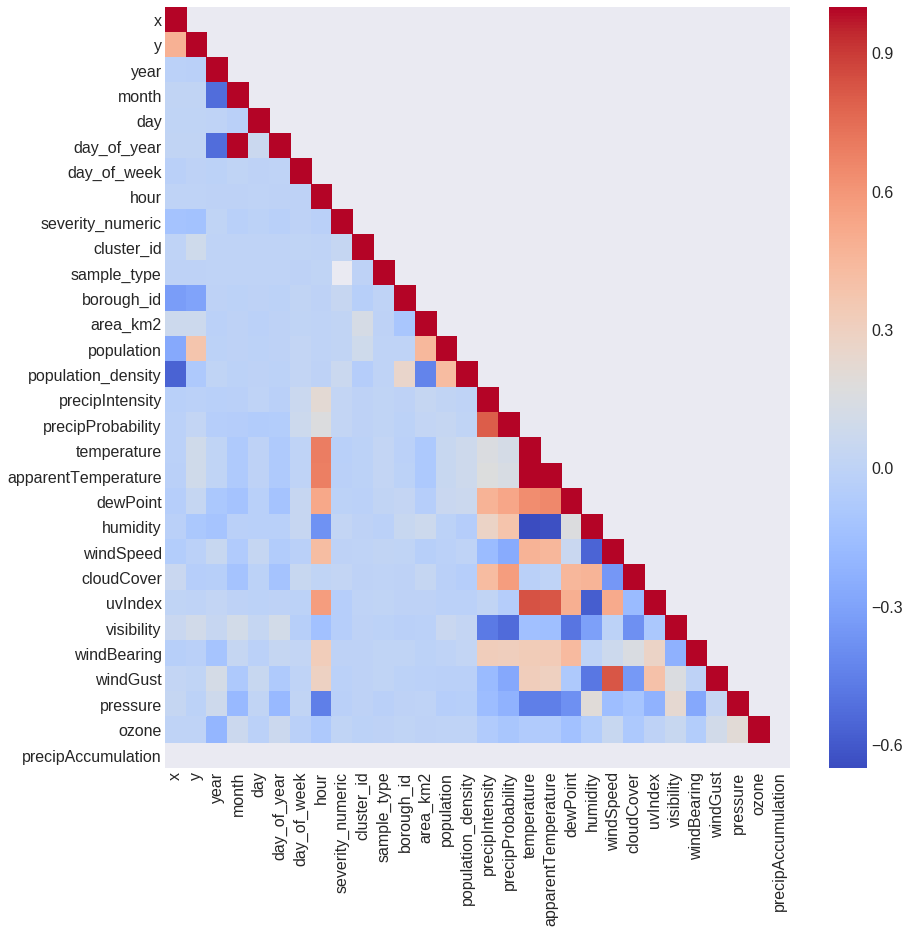

In [13]:
plt.figure(figsize=(14,14))
sns.heatmap(corr.where(np.tril(np.ones(corr.shape)).astype(np.bool)), cmap='coolwarm')
plt.show()

## Useful Functions

In [14]:
def model_fit_predict(X_train, X_test, y_train, y_test, clf):
    categories = ['non-accident', 'accident']
    clf.fit(X_train, y_train)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring= 'roc_auc', n_jobs=-1)
    print('ROC AUC: {:.2f} (+/- {:.3f} )'.format(scores.mean(), scores.std() * 2))

    y_pred = clf.predict(X_test)
    print('Cohen kappa score {:.4f}'.format(cohen_kappa_score(y_pred, y_test)))
    print('F1 score {:.4f}'.format(f1_score(y_pred, y_test,)))
    print('Average precision score {:.4f}'.format(average_precision_score(y_pred, y_test)))
    print(classification_report(y_test, y_pred,target_names=categories))

#     metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
#     scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
#     cv = KFold(n_splits=3)
#     scv = StratifiedKFold(n_splits=3)
#     for metric in metric_names:
#         score1 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1).mean()
#         score2 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=scv, n_jobs=-1).mean()
#         scores_df.loc[metric] = [score1, score2]
#     print(scores_df)
    y_pred_proba = clf.predict_proba(X_test)[:,1]

    return clf, y_pred, y_pred_proba


In [15]:
def model_plot(y_test, y_pred, y_pred_proba, model_name):
    categories = ['non-accident', 'accident']
    gs = mpl.gridspec.GridSpec(2, 2)

    plt.figure(figsize=(14,10))
    ax = plt.subplot(gs[0, 0]) # row 0, col 0
    labels = [0,1]
    cnf_mx = confusion_matrix(y_test,y_pred,labels=labels)
    ax1 = sns.heatmap(cnf_mx, cmap='Blues',annot=True, fmt="d")
    plt.xticks([0.5,1.5],categories, rotation=0)
    plt.yticks([0.5,1.5],categories, rotation=0)
    plt.title(f'Confusion matrix {model_name}', fontsize=18)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    ax = plt.subplot(gs[0, 1]) # row 0, col 1
    row_sums = cnf_mx.sum(axis=1, keepdims=True)
    norm_cnf_mx = cnf_mx / row_sums
    np.fill_diagonal(norm_cnf_mx, 0)
    ax2 = sns.heatmap(norm_cnf_mx, cmap='Blues',annot=True, fmt=".4%")
    plt.xticks([0.5,1.5],categories, rotation=0)
    plt.yticks([0.5,1.5],categories, rotation=0)
    plt.title(f'Error matrix {model_name}', fontsize=18)
    plt.xlabel('Predicted label')

    ax = plt.subplot(gs[1, :]) # row 1, span all columns
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    # Display plot for AUC curve
    ax3 = plt.plot(fpr,tpr,label= f"{model_name}, auc={round(auc,4)}")
    ax3 = plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
    plt.legend(fontsize=14)
    plt.title(f"ROC cuve: {model_name}", fontsize= 18)
    plt.tight_layout()
    plt.show()

In [16]:
def generate_cyclical_variables(df, column, period):
    if df[column].min() != 0:
        df[f'{column}_sin'] = np.sin((df[column] - 1)*(2.*np.pi/period))
        df[f'{column}_cos'] = np.cos((df[column] - 1)*(2.*np.pi/period))
    else:
        df[f'{column}_sin'] = np.sin((df[column])*(2.*np.pi/period))
        df[f'{column}_cos'] = np.cos((df[column])*(2.*np.pi/period))

    return df

In [17]:
def generate_precipitation_intensity(df, column_intensity, column_probability):
    df['precip_intensity_probability'] = df.precipIntensity * df.precipProbability
    return df

In [18]:
# data = (data.pipe(generate_precipitation_intensity, column_intensity='precipIntensity', column_probability = 'precipProbability' )
#  .pipe(generate_cyclical_variables, column='hour', period = 24)
#  .pipe(generate_cyclical_variables, column='day_of_week', period = 7)
#  .pipe(generate_cyclical_variables, column='month', period = 12)
#  .pipe(generate_cyclical_variables, column='day_of_year', period = 365)
# )

In [19]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self._feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X.loc[:,self._feature_names ] 

In [28]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class IntensityProba( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, column_intensity, column_probability ):
        self.column_intensity = column_intensity 
        self.column_probability = column_probability
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        X.loc[:,'precip_intensity_probability'] = X[self.column_intensity] * X[self.column_probability]
        return X.drop([self.column_intensity, self.column_probability], axis=1)

In [29]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class CyclicalGenerator( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, column, period ):
        self.column = column 
        self.period = period
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        if X[self.column].min() != 0:
            X.loc[:,f'{self.column}_sin'] = np.sin((X[self.column] - 1)*(2.*np.pi/self.period))
            X.loc[:,f'{self.column}_cos'] = np.cos((X[self.column] - 1)*(2.*np.pi/self.period))
        else:
            X.loc[:,f'{self.column}_sin'] = np.sin((X[self.column])*(2.*np.pi/self.period))
            X.loc[:,f'{self.column}_cos'] = np.cos((X[self.column])*(2.*np.pi/self.period))

        return X.drop(self.column, axis=1)

In [30]:
class ExtractDateParts( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, datime_column):
        self.datime_column = datime_column 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        X.loc[:,'day_of_year'] = pd.to_datetime(X[self.datime_column]).dt.dayofyear
        X.loc[:,'day_of_week'] = pd.to_datetime(X[self.datime_column]).dt.dayofweek
        X.loc[:,'month'] = pd.to_datetime(X[self.datime_column]).dt.month
        X.loc[:,'hour'] = pd.to_datetime(X[self.datime_column]).dt.hour
  
        return   X.drop(self.datime_column, axis=1)

In [31]:
cols_front_end = ['x', 'y','timestamp']
cols_to_keep_weather = [ 
       'precipIntensity', 'precipProbability', 'temperature', 
       'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'uvIndex', 'visibility',
       'pressure', 'ozone']
cols_to_keep = cols_front_end + cols_to_keep_weather
target_feature = ['sample_type']

In [32]:
pipeline_preprocess = Pipeline([
    ('select_cols', FeatureSelector(cols_to_keep)),
    ('date_parts', ExtractDateParts('timestamp')),
    ('cyclical_hour', CyclicalGenerator('hour', 24)),
    ('cyclical_dow', CyclicalGenerator('day_of_week', 12)),
    ('cyclical_month', CyclicalGenerator('month', 24)),
    ('cyclical_doy', CyclicalGenerator('day_of_year', 24) ),
    ('intesity_proba', IntensityProba('precipIntensity', 'precipProbability')),
])

data_prepared_df = pipeline_preprocess.fit_transform(data)

In [33]:
data_prepared_df.head(2)

,x,y,temperature,dewPoint,humidity,windSpeed,cloudCover,uvIndex,visibility,pressure,ozone,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos,precip_intensity_probability
0,-74.154268,4.622942,14.62,12.92,0.90,1.48,0.74,5.0,8.278,1015.4,268.4,-0.500000,-0.866025,0.866025,-0.500000,0.866025,-0.5,-0.866025,-0.500000,0.087780
1,-74.051403,4.722273,19.41,12.60,0.65,2.33,0.71,8.0,16.093,1013.1,266.2,-0.707107,-0.707107,0.500000,-0.866025,0.866025,-0.5,0.965926,-0.258819,0.016709


In [34]:
full_pipeline = Pipeline([
    ('preprocess', pipeline_preprocess),
    ('scaler', MinMaxScaler()),
])

In [35]:
data_prepared = full_pipeline.fit_transform(data)

In [38]:
data_prepared
labels = data[target_feature].values

## Model

In [39]:
X_train, X_test_val, y_train, y_test_val = train_test_split(data_prepared, labels, test_size=0.33, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.33, random_state = 42)


In [96]:
%%time
clf = RandomForestClassifier(n_estimators=150, max_leaf_nodes=50, min_samples_leaf=200, max_features=10, n_jobs=-1, criterion='entropy')

clf, y_pred, y_pred_proba = model_fit_predict(X_train, X_val, y_train.ravel(), y_val.ravel(), clf)

ROC AUC: 0.64 (+/- 0.015 )
Cohen kappa score 0.2086
F1 score 0.5358
Average precision score 0.4218
              precision    recall  f1-score   support

non-accident       0.58      0.75      0.66      4369
    accident       0.64      0.46      0.54      4303

    accuracy                           0.61      8672
   macro avg       0.61      0.60      0.60      8672
weighted avg       0.61      0.61      0.60      8672

CPU times: user 48.6 s, sys: 239 ms, total: 48.9 s
Wall time: 1min 14s


In [97]:
rf_feature_importance = pd.DataFrame(clf.feature_importances_,
                                   index =data_prepared_df.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

In [98]:
rf_feature_importance

,importance
uvIndex,0.326644
hour_sin,0.192567
hour_cos,0.191444
apparentTemperature,0.053947
temperature,0.045822
visibility,0.034883
pressure,0.024130
cloudCover,0.022892
windSpeed,0.020325
precip_intensity_probability,0.017927


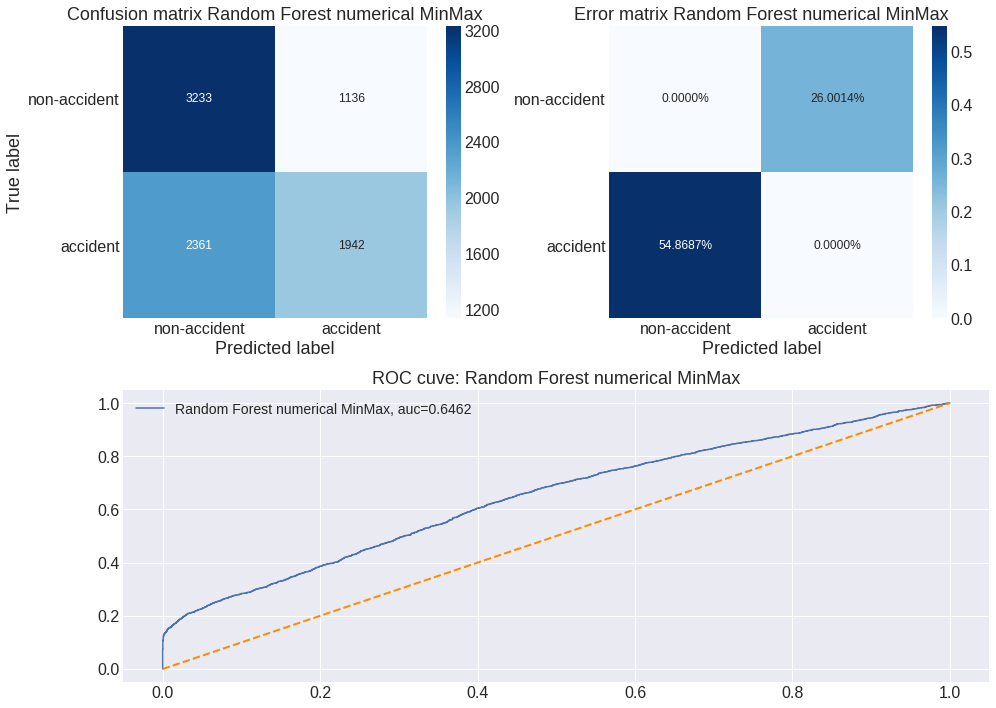

In [57]:
model_plot(y_val, y_pred, y_pred_proba, 'Random Forest numerical MinMax')

## Fine tune model

In [50]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [100, 200, 500], 
     'max_features': [4, 6, 8, 10],
     'max_leaf_nodes': [4, 10, 100, 1000],
     'min_samples_leaf': [10,100,100]
    }
  ]

forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
# train across 3 folds, that's a total of (4*3*3*3*3)*3=432 rounds of training 
grid_search = GridSearchCV(forest_clf, param_grid, cv=3,
                           scoring=['f1', 'roc_auc'], refit='f1',
                           return_train_score=True, verbose=2)
grid_search.fit(data_prepared, labels.ravel())

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] max_features=4, max_leaf_nodes=4, min_samples_leaf=10, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=4, max_leaf_nodes=4, min_samples_leaf=10, n_estimators=100, total=   2.7s
[CV] max_features=4, max_leaf_nodes=4, min_samples_leaf=10, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV]  max_features=4, max_leaf_nodes=4, min_samples_leaf=10, n_estimators=100, total=   2.3s
[CV] max_features=4, max_leaf_nodes=4, min_samples_leaf=10, n_estimators=100 
[CV]  max_features=4, max_leaf_nodes=4, min_samples_leaf=10, n_estimators=100, total=   2.1s
[CV] max_features=4, max_leaf_nodes=4, min_samples_leaf=10, n_estimators=200 
[CV]  max_features=4, max_leaf_nodes=4, min_samples_leaf=10, n_estimators=200, total=   4.2s
[CV] max_features=4, max_leaf_nodes=4, min_samples_leaf=10, n_estimators=200 
[CV]  max_features=4, max_leaf_nodes=4, min_samples_leaf=10, n_estimators=200, total=   4.2s
[CV] max_features=4, max_leaf_nodes=4, min_samples_leaf=10, n_estimators=200 
[CV]  max_features=4, max_leaf_nodes=4, min_samples_leaf=10, n_estimators=200, total=   4.3s
[CV] max_features=4, max_leaf_nodes=4, min_samples_leaf=10, n_estimators=500 
[CV]  max_features=4, max_leaf_nodes=4, min_samples_leaf=10, n_estimators=500, total=   9.7s
[CV] max_features=4, max_leaf_nodes=4, min_samples_l

[CV]  max_features=4, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=200, total=   5.1s
[CV] max_features=4, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=200 
[CV]  max_features=4, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=200, total=   6.1s
[CV] max_features=4, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=500 
[CV]  max_features=4, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=500, total=  12.6s
[CV] max_features=4, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=500 
[CV]  max_features=4, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=500, total=  13.2s
[CV] max_features=4, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=500 
[CV]  max_features=4, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=500, total=  13.0s
[CV] max_features=4, max_leaf_nodes=100, min_samples_leaf=10, n_estimators=100 
[CV]  max_features=4, max_leaf_nodes=100, min_samples_leaf=10, n_estimators=100, total=   4.6s
[CV] max_features=4, max_leaf_

[CV]  max_features=4, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=500, total=  29.7s
[CV] max_features=4, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=500 
[CV]  max_features=4, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=500, total=  28.5s
[CV] max_features=4, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=500 
[CV]  max_features=4, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=500, total=  27.4s
[CV] max_features=4, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=100 
[CV]  max_features=4, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=100, total=   5.5s
[CV] max_features=4, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=100 
[CV]  max_features=4, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=100, total=   5.1s
[CV] max_features=4, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=100 
[CV]  max_features=4, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=100, total=   5.1s
[CV] max

[CV]  max_features=6, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=100, total=   4.0s
[CV] max_features=6, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=100 
[CV]  max_features=6, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=100, total=   3.3s
[CV] max_features=6, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=100 
[CV]  max_features=6, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=100, total=   3.5s
[CV] max_features=6, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=200 
[CV]  max_features=6, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=200, total=   8.0s
[CV] max_features=6, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=200 
[CV]  max_features=6, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=200, total=  11.6s
[CV] max_features=6, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=200 
[CV]  max_features=6, max_leaf_nodes=10, min_samples_leaf=100, n_estimators=200, total=   7.3s
[CV] max_features=6, max_leaf_

[CV]  max_features=6, max_leaf_nodes=1000, min_samples_leaf=10, n_estimators=100, total=   8.8s
[CV] max_features=6, max_leaf_nodes=1000, min_samples_leaf=10, n_estimators=200 
[CV]  max_features=6, max_leaf_nodes=1000, min_samples_leaf=10, n_estimators=200, total=  19.0s
[CV] max_features=6, max_leaf_nodes=1000, min_samples_leaf=10, n_estimators=200 
[CV]  max_features=6, max_leaf_nodes=1000, min_samples_leaf=10, n_estimators=200, total=  17.0s
[CV] max_features=6, max_leaf_nodes=1000, min_samples_leaf=10, n_estimators=200 
[CV]  max_features=6, max_leaf_nodes=1000, min_samples_leaf=10, n_estimators=200, total=  17.1s
[CV] max_features=6, max_leaf_nodes=1000, min_samples_leaf=10, n_estimators=500 
[CV]  max_features=6, max_leaf_nodes=1000, min_samples_leaf=10, n_estimators=500, total=  43.6s
[CV] max_features=6, max_leaf_nodes=1000, min_samples_leaf=10, n_estimators=500 
[CV]  max_features=6, max_leaf_nodes=1000, min_samples_leaf=10, n_estimators=500, total=  42.8s
[CV] max_features=6

[CV]  max_features=8, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=200, total=   5.7s
[CV] max_features=8, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=200 
[CV]  max_features=8, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=200, total=   5.8s
[CV] max_features=8, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=500 
[CV]  max_features=8, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=500, total=  13.7s
[CV] max_features=8, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=500 
[CV]  max_features=8, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=500, total=  14.2s
[CV] max_features=8, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=500 
[CV]  max_features=8, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=500, total=  14.3s
[CV] max_features=8, max_leaf_nodes=10, min_samples_leaf=10, n_estimators=100 
[CV]  max_features=8, max_leaf_nodes=10, min_samples_leaf=10, n_estimators=100, total=   3.6s
[CV] max_features=8, max_leaf_nodes=10, m

[CV]  max_features=8, max_leaf_nodes=100, min_samples_leaf=100, n_estimators=500, total=  37.1s
[CV] max_features=8, max_leaf_nodes=100, min_samples_leaf=100, n_estimators=500 
[CV]  max_features=8, max_leaf_nodes=100, min_samples_leaf=100, n_estimators=500, total=  36.3s
[CV] max_features=8, max_leaf_nodes=100, min_samples_leaf=100, n_estimators=500 
[CV]  max_features=8, max_leaf_nodes=100, min_samples_leaf=100, n_estimators=500, total=  35.4s
[CV] max_features=8, max_leaf_nodes=100, min_samples_leaf=100, n_estimators=100 
[CV]  max_features=8, max_leaf_nodes=100, min_samples_leaf=100, n_estimators=100, total=   7.4s
[CV] max_features=8, max_leaf_nodes=100, min_samples_leaf=100, n_estimators=100 
[CV]  max_features=8, max_leaf_nodes=100, min_samples_leaf=100, n_estimators=100, total=   7.3s
[CV] max_features=8, max_leaf_nodes=100, min_samples_leaf=100, n_estimators=100 
[CV]  max_features=8, max_leaf_nodes=100, min_samples_leaf=100, n_estimators=100, total=   7.1s
[CV] max_features=8

[CV]  max_features=10, max_leaf_nodes=4, min_samples_leaf=10, n_estimators=500, total=  17.0s
[CV] max_features=10, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=100 
[CV]  max_features=10, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=100, total=   3.3s
[CV] max_features=10, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=100 
[CV]  max_features=10, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=100, total=   3.3s
[CV] max_features=10, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=100 
[CV]  max_features=10, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=100, total=   3.4s
[CV] max_features=10, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=200 
[CV]  max_features=10, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=200, total=   6.5s
[CV] max_features=10, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=200 
[CV]  max_features=10, max_leaf_nodes=4, min_samples_leaf=100, n_estimators=200, total=   6.5s
[CV] max_features=10, max_leaf_

[CV]  max_features=10, max_leaf_nodes=100, min_samples_leaf=10, n_estimators=100, total=   8.5s
[CV] max_features=10, max_leaf_nodes=100, min_samples_leaf=10, n_estimators=100 
[CV]  max_features=10, max_leaf_nodes=100, min_samples_leaf=10, n_estimators=100, total=   8.7s
[CV] max_features=10, max_leaf_nodes=100, min_samples_leaf=10, n_estimators=200 
[CV]  max_features=10, max_leaf_nodes=100, min_samples_leaf=10, n_estimators=200, total=  17.1s
[CV] max_features=10, max_leaf_nodes=100, min_samples_leaf=10, n_estimators=200 
[CV]  max_features=10, max_leaf_nodes=100, min_samples_leaf=10, n_estimators=200, total=  17.1s
[CV] max_features=10, max_leaf_nodes=100, min_samples_leaf=10, n_estimators=200 
[CV]  max_features=10, max_leaf_nodes=100, min_samples_leaf=10, n_estimators=200, total=  17.2s
[CV] max_features=10, max_leaf_nodes=100, min_samples_leaf=10, n_estimators=500 
[CV]  max_features=10, max_leaf_nodes=100, min_samples_leaf=10, n_estimators=500, total=  43.3s
[CV] max_features=1

[CV]  max_features=10, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=100, total=   9.8s
[CV] max_features=10, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=200 
[CV]  max_features=10, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=200, total=  20.6s
[CV] max_features=10, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=200 
[CV]  max_features=10, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=200, total=  19.7s
[CV] max_features=10, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=200 
[CV]  max_features=10, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=200, total=  19.4s
[CV] max_features=10, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=500 
[CV]  max_features=10, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=500, total=  50.9s
[CV] max_features=10, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=500 
[CV]  max_features=10, max_leaf_nodes=1000, min_samples_leaf=100, n_estimators=500, total=  48.

[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed: 112.8min finished


CPU times: user 42min 22s, sys: 54.9 s, total: 43min 17s
Wall time: 1h 53min 4s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                    

In [51]:
grid_search.best_params_

{'max_features': 10,
 'max_leaf_nodes': 1000,
 'min_samples_leaf': 100,
 'n_estimators': 100}

In [55]:
%%time
clf, y_pred, y_pred_proba = model_fit_predict(X_train, X_val, y_train.ravel(), y_val.ravel(), grid_search.best_estimator_)

ROC AUC: 0.66 (+/- 0.013 )
Cohen kappa score 0.2293
F1 score 0.5635
Average precision score 0.4594
              precision    recall  f1-score   support

non-accident       0.60      0.73      0.66      4369
    accident       0.64      0.50      0.56      4303

    accuracy                           0.62      8672
   macro avg       0.62      0.61      0.61      8672
weighted avg       0.62      0.62      0.61      8672

CPU times: user 38.4 s, sys: 110 ms, total: 38.5 s
Wall time: 51.3 s


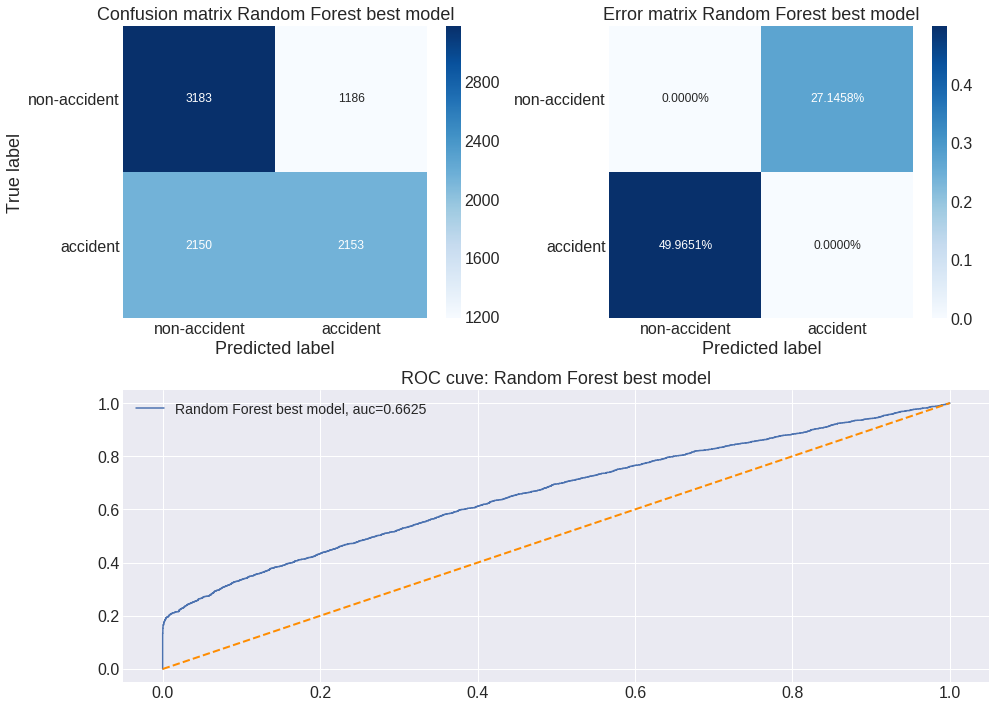

In [54]:
model_plot(y_val, y_pred, y_pred_proba, 'Random Forest best model')

In [56]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=10,
                       max_leaf_nodes=1000, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)